In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

%matplotlib inline

def chi2(mag,mag_err):
    mag = np.array(mag)
    mag_err = np.array(mag_err)
    N = len(mag)
    mean = np.mean(mag)
    return (1/N)*np.sum(  ((mag-mean)/(mag_err))**2 )

In [2]:
# We start by reading the class.txt file with the full database with labels.
classes = pd.read_table("../data/lightcurves/transient_info.txt")

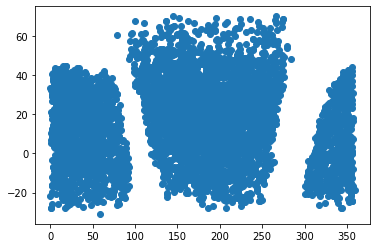

In [3]:
plt.scatter(classes['RA (J2000)'], classes['Dec (J2000)'])

In [4]:
# Select regions to query 
arcmin_in_deg = 1.0/60.0

dec_non_trans = np.array(classes['Dec (J2000)']) + 2.0*arcmin_in_deg
ra_non_trans = np.array(classes['RA (J2000)'])
radius_non_trans = np.ones(len(ra_non_trans))*1.2*arcmin_in_deg
non_trans_id = np.int_(np.ones(len(ra_non_trans))*1E6 + np.arange(len(ra_non_trans))+1.0)

np.savetxt('../data/NON_TRANS_QUERY/all_inputs_to_query.txt', 
           np.array([non_trans_id, ra_non_trans, dec_non_trans, radius_non_trans]).T, fmt="%d %f %f %f")

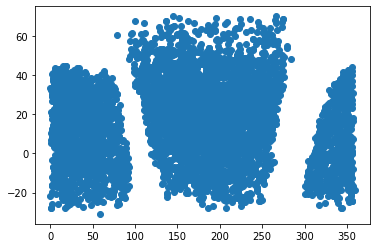

In [5]:
data = np.loadtxt('../data/NON_TRANS_QUERY/all_inputs_to_query.txt')
plt.scatter(data[:,1], data[:,2])

In [6]:
# after using a file to query here http://nesssi.cacr.caltech.edu/cgi-bin/getmulticonedb_release2.cgi, we read the results
data_base_ID = np.loadtxt("../data/CATALINA_PHOT/Database_ID_for_all_transients.dat")

In [7]:
path_data = "../data/NON_TRANS_QUERY/querys/*.csv"
csv_files = !ls $path_data

In [9]:
# after using a file to query here http://nesssi.cacr.caltech.edu/cgi-bin/getmulticonedb_release2.cgi, we read the results
data_base_ID = np.loadtxt("../data/CATALINA_PHOT/Database_ID_for_all_transients.dat")

n_all = 0
n_no_blend = 0
n_no_blend_no_trans = 0

ID_all = np.zeros(len(csv_files), dtype=object)
ID_no_blend = np.zeros(len(csv_files), dtype=object)
ID_no_blend_no_trans = np.zeros(len(csv_files), dtype=object)

pbar = tqdm(total=len(csv_files))
ii = 0

for i in csv_files:
#     print(i)

    query_result = pd.read_csv(i)
    df = pd.DataFrame(query_result)
#     print(df["ID"][-3:],end="\n\n\n\n")

    # Remove the uncompleted queries 
    df = df[:39999]
#     print(df["ID"][-3:],end="\n\n\n\n")

    # Remove the cutted times series
    df = df[df["ID"] != df["ID"].iloc[-1]]
    new_file = "../data/NON_TRANS_QUERY/"+i[-30:-4]+"_p.csv"

    df.to_csv(new_file, index=False)
#     print(df["ID"][-3:],end="\n\n\n\n")

    query_result = pd.read_csv(new_file)
    df = pd.DataFrame(query_result)
#     print(df["ID"][-3:],end="\n\n\n\n")

    #all IDs
    id_all = np.array(list(set(query_result['ID'])))
    ID_all[ii] = id_all
    n_all += len(id_all)

    #IDs discarding blended sources
    id_no_blend =  np.array(list(set(id_all) - set(query_result[query_result['Blend']==1]['ID'])))
    ID_no_blend[ii] = id_no_blend
    n_no_blend += len(id_no_blend)

    #IDs discarding transient sources
    id_no_blend_no_trans = np.array(list(set(id_no_blend)-set(data_base_ID)))
    ID_no_blend_no_trans[ii] = id_no_blend_no_trans
    n_no_blend_no_trans += len(id_no_blend_no_trans)

    del(query_result)
    del(id_all)
    del(id_no_blend)
    del(id_no_blend_no_trans)

    ii = ii + 1
    pbar.update(1)
pbar.close()

In [10]:
# The IDs of the no_transients and no_transients+no_blend are stored
print(n_all)
print(n_no_blend_no_trans)
ID_all = np.concatenate(ID_all).ravel().astype(int)
ID_no_blend_no_trans = np.concatenate(ID_no_blend_no_trans).ravel().astype(int)

In [11]:
# np.save("../data/lightcurves/IDs_nontransients_lighcurves.npy",ID_all)
# np.save("../data/lightcurves/IDs_nontransients_nonblend_lighcurves.npy",ID_no_blend_no_trans)

In [12]:
# ID_all = np.load("../data/lightcurves/IDs_nontransients_lighcurves.npy", allow_pickle=True).astype(int)
# ID_no_blend_no_trans = np.load("../data/lightcurves/IDs_nontransients_nonblend_lighcurves.npy", allow_pickle=True).astype(int)

In [13]:
print(len(np.unique(ID_all)))
print(len(np.unique(ID_no_blend_no_trans)))

84276
71207


In [14]:
# The lightcurves of the no_trans+no_blend are stored in a unique csv file
path_data = "../data/NON_TRANS_QUERY/*_p.csv"
csv_files = !ls $path_data

combined_csv = pd.concat([pd.read_csv(f) for f in csv_files])

In [15]:
df = pd.DataFrame(combined_csv)

In [16]:
columns = list(np.array(df.keys()))
columns.append('chi2')
columns = np.array(columns, dtype=object)

In [17]:
# A statistical classification between variables chisq>=1 & non_variables chisq<1 is applied
df_nb_nt = pd.DataFrame(columns=columns)

pbar = tqdm(total=len(ID_no_blend_no_trans))
for i in ID_no_blend_no_trans:
    df_temp = df[df.values == i]

    mag = df_temp['Mag']
    mag_err = df_temp['Magerr']
    chi = chi2(mag,mag_err)

    chi_temp = np.zeros(len(mag)) + chi
    df_temp.insert(2,'chi2', chi_temp, True) 

    df_nb_nt = df_nb_nt.append(df_temp, sort =True)

    pbar.update(1)

pbar.close()
del df, df_temp, chi, chi_temp, mag, mag_err

In [5]:
# df_nb_nt = pd.read_csv("../data/lightcurves/nontransient_lightcurves.csv")
# df_nb_nt.keys()

Index(['Unnamed: 0', 'Blend', 'Decl', 'ID', 'InputID', 'MJD', 'Mag', 'Magerr',
       'RA', 'chi2'],
      dtype='object')

In [6]:
print(len(df_nb_nt['ID'])) #Lightcurves
print(len(np.unique(df_nb_nt['ID']))) #Objects

8091076
71207


In [7]:
# Removing Objects with MJD<0 and duplicated entries
df_nb_nt = df_nb_nt[df_nb_nt.MJD>0] 
df_nb_nt = df_nb_nt.drop_duplicates(df_nb_nt.columns[~df_nb_nt.columns.isin(['ID'])],keep='first')
df_nb_nt = df_nb_nt.drop(columns={'Blend','chi2','Unnamed: 0','InputID'})
df_nb_nt = df_nb_nt[['ID','MJD','Mag','Magerr','RA','Decl']]
df_nb_nt.to_csv("../data/lightcurves/nontransient_lightcurves.csv")
print(df_nb_nt.keys())
print(df_nb_nt)

Index(['ID', 'MJD', 'Mag', 'Magerr', 'RA', 'Decl'], dtype='object')
                   ID          MJD    Mag  Magerr         RA      Decl
0        1.121012e+12  56251.16733  18.09    0.12   33.72388  19.89408
1        1.121012e+12  56251.17237  18.11    0.12   33.72390  19.89372
2        1.121012e+12  56251.17748  18.22    0.13   33.72389  19.89395
3        1.121012e+12  56251.18261  18.22    0.13   33.72386  19.89393
4        1.121012e+12  56263.11047  18.20    0.13   33.72382  19.89405
...               ...          ...    ...     ...        ...       ...
8091071  2.108327e+12  56295.14281  18.27    0.08  356.04127   7.89939
8091072  2.108327e+12  56578.11151  18.27    0.08  356.04135   7.89943
8091073  2.108327e+12  56578.11854  18.28    0.08  356.04131   7.89943
8091074  2.108327e+12  56578.12556  18.22    0.08  356.04135   7.89940
8091075  2.108327e+12  56578.13255  18.26    0.08  356.04132   7.89943

[8091070 rows x 6 columns]


In [25]:
df_var = df_nb_nt[df_nb_nt['chi2']>=1]
df_no_var = df_nb_nt[df_nb_nt['chi2']<1]

df_var.to_csv("../data/lightcurves/nontransient_nonblend_variable_lightcurves.csv", index=False)
df_no_var.to_csv("../data/lightcurves/nontransient_nonblend_nonvariable_lightcurves.csv", index=False)
del df_var, df_no_var

In [26]:
query_no_blend_no_trans_no_var = pd.read_csv("../data/lightcurves/nontransient_nonblend_nonvariable_lightcurves.csv")
query_no_blend_no_trans_var = pd.read_csv("../data/lightcurves/nontransient_nonblend_variable_lightcurves.csv")

In [27]:
print(len(np.unique(query_no_blend_no_trans_no_var['ID']))) #Amount of No Blend No Trans No Variables)
print(len(np.unique(query_no_blend_no_trans_var['ID']))) #Amount of No Blend No Trans Variables

25654
45553


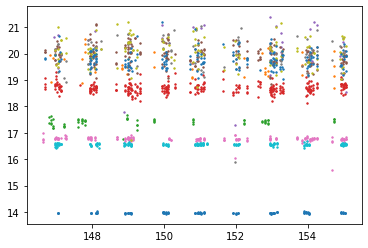

In [28]:
for i in ID_no_blend_no_trans[:20]:
    l = len((query_no_blend_no_trans[query_no_blend_no_trans['ID']==i]['MJD']))
    if l > 30:
        plt.scatter(query_no_blend_no_trans[query_no_blend_no_trans['ID']==i]['MJD']/365.0, query_no_blend_no_trans[query_no_blend_no_trans['ID']==i]['Mag'],s=2)
#         print(len((query_no_blend_no_trans[query_no_blend_no_trans['ID']==i]['MJD'])))
plt.show()

In [ ]:
# We create a new column with the trasient class name
n_elements  = len(classes)
classification = []
for i in range(n_elements):
    classification.append(classes['Classification'][i].split()[0])
classes['class'] = classification
classes = classes.rename(columns={"CSS images":"transID"})
classes = classes.set_index("transID")
print(len(classes.index))
print(len(np.unique(classes.index)))
classes[:10]

# look for transID in orphan data
cuenta = open('cuenta_en_orph.sh', 'w')
for i in classes.index:
    cuenta.write("grep {} *.orph |wc -l\n".format(i))
cuenta.close()

In [ ]:
# With the 'CSS_images' we have to link to the 'dbID' that is provided in the *.out 
# files. That's why we read them here:

In [ ]:
out_files  = glob.glob("../../mantra_data/CATALINA_PHOT/*.out")
print(out_files)

In [ ]:
out_data = pd.read_table(out_files[0], sep=' ',header=None, names=['transID', 'dbID', 'mag_out', 'ra_out', 'dec_out'])
for i in range(1,len(out_files)):
    tmp_data = pd.read_table(out_files[i], sep=' ',header=None, names=['transID', 'dbID', 'mag_out', 'ra_out', 'dec_out'])
    out_data = pd.concat([out_data, tmp_data])
out_data = out_data.set_index("transID")
#print(len(out_data))
print(len(out_data.index))
print('unicos', len(np.unique(out_data['dbID'])))
out_data[:10]

# look for dbID in phot data
cuenta = open('cuenta_en_phot.sh', 'w')
for i in out_data['dbID']:
    cuenta.write("grep {} *.phot |wc -l\n".format(i))
cuenta.close()
#out_data['transID']

In [ ]:
# look for the link 'CSS images'->'dbID'
n_elements  = len(classes)
dbID = []
for i in range(n_elements):
    classification.append(classes['Classification'][i].split()[0])
classes['class'] = classification

In [ ]:
idtrans_orph = np.loadtxt('../../matra_data/CATALINA_PHOT/ID_trans_para_cuenta_en_orph', dtype=int)
n_orph = np.loadtxt('../../matra_data/CATALINA_PHOT/conteo_orph', dtype=int)
print(len(idtrans_orph))
iddb_phot = np.loadtxt('../../matra_data/CATALINA_PHOT/ID_DB_para_cuenta_en_phot', dtype=int)
n_phot = np.loadtxt('../../matra_data/CATALINA_PHOT/conteo_phot', dtype=int)
print(len(n_phot))
idtrans_orph[0:10]

In [ ]:
curvas_existentes = 0
curvas_inexistentes = 0
n_esperadas = len(idtrans_orph)
print(n_esperadas)
pp=0
for i in range(n_esperadas): # busco en todas los indices de las transientes de entrada
    #print('ENTRA', idtrans_orph[i])
    if idtrans_orph[i] in out_data.index: # miro si este indice de transiente tiene un IDdb asociado
        iddb  = np.int_(out_data.loc[idtrans_orph[i]]['dbID'])
        if np.isscalar(iddb): # pude que un valor de idtrans sea uno solo en iddb
            #print('\t dbID', iddb)
            ii = np.where(iddb==iddb_phot)[0]
            if n_phot[ii][0] > 0: # busco este IDdb in phot
                #print('\t NOT ORPHAN {}'.format(n_phot[ii][0]))
                curvas_existentes +=1
            else:
                curvas_inexistentes +=1
        else: # pero tambien puede ser que un valor de idtrans sea varios in iddb.

            n_in_phot = n_phot[np.in1d(iddb_phot, iddb)]
            if n_in_phot[0]==n_in_phot[1]:
                print(idtrans_orph[i], iddb, n_in_phot)
                pp+=1
            if np.all(n_in_phot==0): # busco este IDdb in phot
                curvas_inexistentes +=1
            else:
                curvas_existentes +=1
 
        #ii = ==iddb_phot
    elif n_orph[i]>0: # si no esta en phot miro si esta en orph
        #print('\t ORPHAN {}'.format(n_orph[i]))
        curvas_existentes +=1
    else:
        curvas_inexistentes +=1
print(curvas_existentes, curvas_inexistentes, curvas_existentes+curvas_inexistentes)
print(pp)

In [ ]:
out_data